### Investigating network similarity for the analysis of fish behaviour

In [1]:
import os
import numpy as np
import netrd, networkx as nx
import statistics
import pandas as pd
import itertools
import matplotlib.pyplot as plt


"""
lists directory, each element with its full path
"""
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]


"""
Returns Jaccard distance for weighted directed networks 
"""
def weighted_jaccard(g1,g2):
    e1 = set(g1.edges)
    e2 = set(g2.edges)
    cup = set.union(e1, e2)
    cap = set.intersection(e1, e2)

    #if edge weights are different only add the relative accordance
    relative_sum = 0
    for edge in cap:
        w1 = g1.get_edge_data(edge[0], edge[1])["label"]
        w2 = g2.get_edge_data(edge[0], edge[1])["label"]
        if w1 > w2:
            relative_sum = relative_sum + (w2 / w1)
        elif w2 > w1:
            relative_sum = relative_sum + (w1 / w2)
        else:
            relative_sum = relative_sum +1

    dist = 1 - relative_sum / len(cup)
    return dist


"""
Returns Frobenius norm for weighted directed graphs.
"""
def weighted_frobenius(g1,g2):

    #print(nx.get_edge_attributes(g1, label))
    not_in_g1 = np.setdiff1d(g2.nodes(),g1.nodes())
    g1.add_nodes_from(not_in_g1)
    not_in_g2 = np.setdiff1d(g1.nodes(),g2.nodes())
    g2.add_nodes_from(not_in_g2)
    
    adj1 = nx.to_numpy_array(g1, weight="label")
    adj2 = nx.to_numpy_array(g2, weight="label")
    dist = np.linalg.norm((adj1 - adj2))
    
    return dist



#lists with the files
oce_bvr = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized/ocellatus-behaviours/")
mul_bvr = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized/multi-behaviours/")
tem_bvr = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized/tempo-behaviours/")

oce_ctg = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized/ocellatus-categories/")
mul_ctg = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized/multi-categories/")
tem_ctg = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized/tempo-categories/")

behaviours = [oce_bvr, mul_bvr, tem_bvr]
categories = [oce_ctg, mul_ctg, tem_ctg]

# list with algorithms to apply
distance_algs =  [netrd.distance.Hamming(),
                  netrd.distance.Frobenius(),
                  'weighted_frobenius',
                  netrd.distance.PortraitDivergence(),
                  netrd.distance.JaccardDistance(), 
                  'weighted_jaccard',
]
#distance_algs = [netrd.distance.DeltaCon()]
#names 
algs = ['hamming', 'frobenius', 'weighted_frobenius', 'portrait_divergence', 
        'jaccard_distance', 'weighted_jaccard', 'ged']
#algs = ['deltacon']
#istance_algs = [netrd.distance.PortraitDivergence()]
same_nodes_algs = ['hamming', 'frobenius', 'deltacon']

results= []
df = pd.DataFrame(columns=['alg', 'data1', 'data2', 'results'])
general_df = pd.DataFrame(columns=['alg', 'data', 'type', 'results'])

for alg in distance_algs:
    if alg == 'weighted_jaccard':
        alg_name = alg
    elif alg == 'weighted_frobenius':
        alg_name = alg
    else:
        alg_name = str(alg).split(".")[2]
    print(alg_name)
    
    #lists for specieal results
    bhvr_across_species = []
    bhvr_within_species = []
    cat_across_species = []
    cat_within_species = []
    
    #BEHAVIOURS PAIRWISE
    for data1, data2 in itertools.combinations(behaviours, 2):
        #folder names for adding in dataframe
        folder1 = str(data1).split("/")[7]
        folder2 = str(data2).split("/")[7]
        #compare each folder with each other
        for a in data1:
            for b in data2:

                #read gpickles into networkx
                g1 = nx.read_gpickle(a)
                g2 = nx.read_gpickle(b)
                
                for edge in g1.edges:
                    weight = g1.get_edge_data(edge[0],edge[1])['label']
                    g1[edge[0]][edge[1]]['weight'] = weight
                    
                for edge in g2.edges:
                    weight = g2.get_edge_data(edge[0],edge[1])['label']
                    g2[edge[0]][edge[1]]['weight'] = weight

                # if alg requires same nodeset, add nodes
                if alg_name in same_nodes_algs:    
                    not_in_g1 = np.setdiff1d(g2.nodes(),g1.nodes())
                    g1.add_nodes_from(not_in_g1)
                    not_in_g2 = np.setdiff1d(g1.nodes(),g2.nodes())
                    g2.add_nodes_from(not_in_g2)

                #calculate and append results
                if alg_name == 'weighted_jaccard':
                    results.append(weighted_jaccard(g1,g2))
                elif alg_name == 'weighted_frobenius':
                    results.append(weighted_frobenius(g1,g2))
                else:
                    dist = alg
                    d = dist.dist(g1, g2)
                    results.append(d)
               


        #calculate statistics and append to across species list
        df.loc[len(df.index)] = [alg_name,folder1, folder2, results]
        bhvr_across_species.extend(results)
        results = []
        
    #add row for behaviours across species
    general_df.loc[len(general_df.index)] = [alg_name, 'across species', 'behaviours', bhvr_across_species]    
        
        
    #CATEGORIES PAIRWISE
    for data1, data2 in itertools.combinations(categories, 2):
        #folder names for adding in dataframe
        folder1 = str(data1).split("/")[7]
        folder2 = str(data2).split("/")[7]
        #compare each folder with each other
        for a in data1:
            for b in data2:

                #read gpickles into networkx
                g1 = nx.read_gpickle(a)
                g2 = nx.read_gpickle(b)

                # if alg requires same nodeset, add nodes
                if alg_name in same_nodes_algs:    
                    not_in_g1 = np.setdiff1d(g2.nodes(),g1.nodes())
                    g1.add_nodes_from(not_in_g1)
                    not_in_g2 = np.setdiff1d(g1.nodes(),g2.nodes())
                    g2.add_nodes_from(not_in_g2)

               
                #calculate and append results
                if alg_name == 'weighted_jaccard':
                    results.append(weighted_jaccard(g1,g2))
                elif alg_name == 'weighted_frobenius':
                    results.append(weighted_frobenius(g1,g2))
                else:
                    dist = alg
                    d = dist.dist(g1, g2)
                    results.append(d)
                
        #calculate statistics
        df.loc[len(df.index)] = [alg_name,folder1, folder2, results]
        cat_across_species.extend(results)
        results = []
        
    #add row for behaviours across species
    general_df.loc[len(general_df.index)] = [alg_name, 'across species', 'behavioural category', cat_across_species]  
        
    #CATEGORIES SINGLE
    for data in categories:
        #folder names for adding in dataframe
        folder1 = str(data).split("/")[7]
        folder2 = str(data).split("/")[7]
        #compare each folder with each other
        for a,b in itertools.combinations(data, 2):

                #read gpickles into networkx
                g1 = nx.read_gpickle(a)
                g2 = nx.read_gpickle(b)

                # if alg requires same nodeset, add nodes
                if alg_name in same_nodes_algs:    
                    not_in_g1 = np.setdiff1d(g2.nodes(),g1.nodes())
                    g1.add_nodes_from(not_in_g1)
                    not_in_g2 = np.setdiff1d(g1.nodes(),g2.nodes())
                    g2.add_nodes_from(not_in_g2)

                
                #calculate and append results
                if alg_name == 'weighted_jaccard':
                    results.append(weighted_jaccard(g1,g2))
                elif alg_name == 'weighted_frobenius':
                    results.append(weighted_frobenius(g1,g2))
                else:
                    dist = alg
                    d = dist.dist(g1, g2)
                    results.append(d)

        #calculate statistics
        df.loc[len(df.index)] = [alg_name,folder1, folder2, results]
        cat_within_species.extend(results)
        results = []
        
    #add row for behaviours across species
    general_df.loc[len(general_df.index)] = [alg_name, 'within species', 'behavioural category', cat_within_species]  
        
        
    #BEHAVIOURS SINGLE
    for data in behaviours:
        #folder names for adding in dataframe
        folder1 = str(data).split("/")[7]
        folder2 = str(data).split("/")[7]
        #compare each folder with each other
        for a,b in itertools.combinations(data, 2):

                #read gpickles into networkx
                g1 = nx.read_gpickle(a)
                g2 = nx.read_gpickle(b)

                # if alg requires same nodeset, add nodes
                if alg_name in same_nodes_algs:    
                    not_in_g1 = np.setdiff1d(g2.nodes(),g1.nodes())
                    g1.add_nodes_from(not_in_g1)
                    not_in_g2 = np.setdiff1d(g1.nodes(),g2.nodes())
                    g2.add_nodes_from(not_in_g2)

               
                #calculate and append results
                if alg_name == 'weighted_jaccard':
                    results.append(weighted_jaccard(g1,g2))
                elif alg_name == 'weighted_frobenius':
                    results.append(weighted_frobenius(g1,g2))
                else:
                    dist = alg
                    d = dist.dist(g1, g2)
                    results.append(d)

        #calculate statistics
        df.loc[len(df.index)] = [alg_name,folder1, folder2, results]
        bhvr_within_species.extend(results)
        results = []
        
    #add row for behaviours across species
    general_df.loc[len(general_df.index)] = [alg_name, 'within species', 'behaviours', bhvr_within_species] 


hamming


C:\Users\nicol\anaconda3\envs\fish\lib\site-packages\netrd\utilities\graph.py:118: RuntimeWarning: Coercing weighted graph to unweighted.
  warnings.warn("Coercing weighted graph to unweighted.", RuntimeWarning)


frobenius
weighted_frobenius
portrait_divergence
jaccard_distance
weighted_jaccard


In [2]:
general_df

,alg,data,type,results
0,hamming,across species,behaviours,"[0.18518518518518517, 0.2299168975069252, 0.19..."
1,hamming,across species,behavioural category,"[0.3469387755102041, 0.390625, 0.2653061224489..."
2,hamming,within species,behavioural category,"[0.22448979591836735, 0.3055555555555556, 0.26..."
3,hamming,within species,behaviours,"[0.1001890359168242, 0.14814814814814814, 0.14..."
4,frobenius,across species,behaviours,"[7.745966692414834, 9.1104335791443, 8.3066238..."
5,frobenius,across species,behavioural category,"[4.123105625617661, 5.0, 3.605551275463989, 4...."
6,frobenius,within species,behavioural category,"[3.3166247903554, 3.3166247903554, 3.605551275..."
7,frobenius,within species,behaviours,"[7.280109889280518, 6.928203230275509, 7.14142..."
8,weighted_frobenius,across species,behaviours,"[3.3974990802059093, 3.655201772816379, 3.7711..."
9,weighted_frobenius,across species,behavioural category,"[1.8243354954612927, 1.884117830710171, 1.5408..."


In [3]:
# add new column 'type' and remove type from data-columns
df['type'] = df.data1

#changing type 
type_mapping = [
    (df['type'] == 'multi-categories', 'behavioural category'),
    (df['type'] == 'tempo-categories', 'behavioural category'),
    (df['type'] == 'ocellatus-categories', 'behavioural category'),
    
    (df['type'] == 'ocellatus-behaviours', 'behaviour'),
    (df['type'] == 'multi-behaviours', 'behaviour'),
    (df['type'] == 'tempo-behaviours', 'behaviour'),
]
condlist = [item[0] for item in type_mapping]
choicelist = [item[1] for item in type_mapping]


df['type'] = np.select(condlist, choicelist)

#changing data column
data1_mapping = [
    (df['data1'] == 'multi-categories', 'multi'),
    (df['data1'] == 'tempo-categories', 'tempo'),
    (df['data1'] == 'ocellatus-categories', 'oclts'),
    
    (df['data1'] == 'ocellatus-behaviours', 'oclts'),
    (df['data1'] == 'multi-behaviours', 'multi'),
    (df['data1'] == 'tempo-behaviours', 'tempo'),
]
condlist = [item[0] for item in data1_mapping]
choicelist = [item[1] for item in data1_mapping]


df['data1'] = np.select(condlist, choicelist)

#changing data2 column
data1_mapping = [
    (df['data2'] == 'multi-categories', 'multi'),
    (df['data2'] == 'tempo-categories', 'tempo'),
    (df['data2'] == 'ocellatus-categories', 'oclts'),
    
    (df['data2'] == 'ocellatus-behaviours', 'oclts'),
    (df['data2'] == 'multi-behaviours', 'multi'),
    (df['data2'] == 'tempo-behaviours', 'tempo'),
]
condlist = [item[0] for item in data1_mapping]
choicelist = [item[1] for item in data1_mapping]


df['data2'] = np.select(condlist, choicelist)
df

,alg,data1,data2,results,type
0,hamming,oclts,multi,"[0.18518518518518517, 0.2299168975069252, 0.19...",behaviour
1,hamming,oclts,tempo,"[0.13541666666666666, 0.1328125, 0.18222222222...",behaviour
2,hamming,multi,tempo,"[0.23129251700680273, 0.27555555555555555, 0.2...",behaviour
3,hamming,oclts,multi,"[0.3469387755102041, 0.390625, 0.2653061224489...",behavioural category
4,hamming,oclts,tempo,"[0.484375, 0.32653061224489793, 0.285714285714...",behavioural category
...,...,...,...,...,...
67,weighted_jaccard,multi,multi,"[0.7378583048653429, 0.6344508641416367, 0.577...",behavioural category
68,weighted_jaccard,tempo,tempo,"[0.7676760123480629, 0.710263407433267, 0.8610...",behavioural category
69,weighted_jaccard,oclts,oclts,"[0.9356019309412504, 0.9005273896902541, 0.893...",behaviour
70,weighted_jaccard,multi,multi,"[0.835296937541728, 0.7874815096996775, 0.8264...",behaviour


In [4]:
# ALT OHNE AVERGAGE TIME ALS NODE ATTRIBUTES

beh_oclts = [27.31, 21.099999999999998, 19.59, 20.97, 15.14, 18.12, 30.56, 22.5, 12.42, 17.87, 29.21, 31.740000000000002, 30.06, 34.190000000000005, 28.83, 30.149999999999995, 31.15, 32.97, 28.9, 16.790000000000003, 17.450000000000003, 20.759999999999998, 15.26, 27.08, 19.46, 21.2, 21.43, 17.379999999999995, 24.49, 26.17, 24.009999999999998, 19.47, 25.309999999999995, 26.039999999999996, 22.25, 21.93, 25.729999999999997, 17.61, 21.97, 23.799999999999997, 16.619999999999997, 28.740000000000002, 19.26, 20.479999999999997, 21.690000000000005, 26.74, 20.0, 22.680000000000003, 21.690000000000005, 29.04, 32.120000000000005, 32.43, 23.619999999999997, 25.349999999999994, 17.47]
beh_multi = [19.730000000000004, 14.270000000000001, 20.209999999999997, 17.650000000000002, 20.45, 20.55, 16.5, 20.24, 23.259999999999998, 18.520000000000003, 20.599999999999998, 21.099999999999998, 16.82, 23.060000000000002, 18.86, 14.520000000000001, 17.259999999999998, 23.240000000000002, 20.24, 23.76, 22.179999999999996]
beh_tempo = [28.83, 30.410000000000007, 24.85, 6.0600000000000005, 9.959999999999999, 8.38]

beh_oclts_multi = [19.04, 23.189999999999998, 19.369999999999997, 25.09, 20.189999999999998, 25.09, 26.87, 31.509999999999998, 28.999999999999996, 31.42, 31.86, 31.979999999999997, 32.16, 31.54, 20.66, 17.669999999999998, 20.37, 16.950000000000003, 20.249999999999996, 19.23, 21.250000000000004, 24.27, 23.42, 26.059999999999995, 25.900000000000002, 25.619999999999997, 24.64, 23.459999999999997, 21.33, 21.5, 23.439999999999998, 23.099999999999998, 23.299999999999997, 23.76, 20.139999999999997, 22.22, 21.53, 20.629999999999995, 25.009999999999998, 22.570000000000004, 24.730000000000004, 26.809999999999995, 21.4, 20.75, 21.389999999999997, 22.269999999999996, 23.49, 22.290000000000003, 24.509999999999998, 31.220000000000002, 29.950000000000003, 31.27, 30.230000000000004, 30.590000000000003, 29.71, 29.57, 19.12, 20.81, 21.89, 24.049999999999997, 24.270000000000003, 24.07, 20.57, 16.639999999999997, 22.73, 18.79, 22.749999999999996, 17.39, 23.45, 26.509999999999998, 18.39, 19.560000000000002, 13.6, 23.38, 21.24, 23.74, 26.32]
beh_oclts_tempo = [28.450000000000003, 26.819999999999997, 24.49, 25.28, 22.14, 28.990000000000002, 28.89, 26.03, 26.149999999999995, 24.81, 28.880000000000003, 11.82, 32.67, 22.999999999999996, 26.290000000000003, 24.17, 22.319999999999997, 24.6, 31.300000000000004, 23.92, 16.02, 20.87, 10.26, 30.410000000000004, 22.740000000000002, 25.009999999999998, 24.470000000000006, 21.659999999999997, 21.640000000000004, 33.080000000000005, 23.7, 17.480000000000004, 15.929999999999998, 8.46, 31.629999999999995, 22.579999999999995, 24.77, 22.71, 21.68, 23.160000000000004, 33.02000000000001, 25.72, 15.22, 18.65]
beh_multi_tempo = [25.810000000000002, 24.299999999999997, 27.619999999999997, 21.9, 24.240000000000002, 22.540000000000003, 25.68, 18.38, 23.289999999999996, 19.009999999999998, 20.13, 15.89, 23.07, 26.130000000000003, 16.5, 18.730000000000004, 16.11, 24.090000000000003, 19.950000000000006, 24.370000000000005, 25.25, 16.16, 19.330000000000002, 15.389999999999999, 20.93, 16.75, 20.51, 22.570000000000004]

cat_oclts = [3.5100000000000002, 2.55, 4.3, 5.380000000000001, 0.44999999999999996, 4.470000000000001, 4.19, 4.43, 1.9, 3.7100000000000004, 3.3600000000000003, 1.33, 4.05, 4.02, 1.7000000000000004, 1.3000000000000005, 1.6000000000000003, 3.8899999999999997, 2.44, 2.9499999999999997, 5.39, 2.42, 3.18, 3.16, 3.38, 2.79, 4.12, 3.7399999999999998, 4.09, 1.99, 1.4300000000000002, 1.2900000000000003, 4.3, 2.59, 5.390000000000001, 3.2700000000000005, 3.9099999999999997, 3.79, 5.78, 3.83, 4.34, 3.7800000000000002, 4.4, 2.1500000000000004, 3.8399999999999994, 1.62, 1.6800000000000002, 3.8299999999999996, 1.8800000000000001, 1.34, 3.67, 2.2399999999999998, 4.09, 2.4800000000000004, 3.67]
cat_multi = [5.75, 4.109999999999999, 1.2599999999999998, 3.3699999999999997, 7.34, 5.85, 7.76, 5.27, 4.52, 4.67, 2.5199999999999996, 3.9499999999999997, 6.300000000000001, 7.1899999999999995, 8.22, 3.15, 7.140000000000001, 5.390000000000001, 6.49, 4.5, 5.289999999999999]
cat_tempo = [6.970000000000001, 6.790000000000002, 7.16, 2.04, 3.77, 2.5700000000000003]
cat_oclts_multi = [6.379999999999999, 9.83, 5.2299999999999995, 5.8999999999999995, 7.83, 10.580000000000002, 9.91, 3.4499999999999997, 7.619999999999999, 2.08, 3.5700000000000003, 5.040000000000001, 8.35, 7.679999999999999, 4.949999999999999, 9.3, 3.5999999999999996, 5.07, 6.98, 9.21, 9.240000000000002, 3.62, 7.57, 2.6700000000000004, 3.5399999999999996, 5.510000000000001, 7.799999999999999, 7.35, 2.12, 5.81, 3.9499999999999993, 1.64, 3.0900000000000003, 6.76, 5.489999999999999, 6.31, 9.620000000000001, 4.9799999999999995, 5.73, 8.18, 10.49, 9.940000000000001, 3.2899999999999996, 7.1, 2.7399999999999998, 3.35, 4.78, 8.87, 7.3999999999999995, 3.5500000000000003, 7.52, 2.5799999999999996, 3.1500000000000004, 5.38, 8.23, 7.26, 3.8099999999999996, 7.619999999999999, 2.5599999999999996, 3.47, 5.76, 7.890000000000001, 7.079999999999999, 5.56, 9.55, 4.93, 5.52, 7.51, 11.120000000000001, 9.27, 4.109999999999999, 8.08, 3.24, 4.2700000000000005, 5.88, 9.03, 8.14]
cat_oclts_tempo = [10.2, 5.989999999999999, 5.050000000000001, 3.42, 7.77, 3.3800000000000003, 3.7, 3.65, 9.11, 5.24, 5.380000000000001, 5.23, 7.279999999999999, 3.3500000000000005, 3.5300000000000002, 3.58, 6.460000000000001, 2.59, 2.23, 2.32, 10.27, 5.9399999999999995, 5.119999999999999, 3.73, 7.91, 3.4, 2.7399999999999998, 2.99, 8.09, 3.66, 3.3000000000000003, 3.63, 7.75, 3.1999999999999997, 3.9400000000000004, 3.83, 10.459999999999999, 5.77, 5.63, 4.76, 8.55, 3.6199999999999997, 4.0, 2.8699999999999997]
cat_multi_tempo = [6.540000000000001, 2.2299999999999995, 1.85, 2.96, 4.09, 6.199999999999999, 6.199999999999999, 7.33, 7.67, 3.96, 4.02, 4.21, 6.58, 2.47, 1.9900000000000002, 3.3400000000000003, 5.6499999999999995, 4.86, 4.0200000000000005, 5.17, 3.7600000000000002, 7.210000000000001, 6.75, 7.68, 4.53, 6.380000000000001, 6.040000000000001, 7.37]


In [5]:
# MIT AVG TIME ALS NODE ATTRIBUTES

beh_oclts = [20.33023917596298, 21.63791727042784, 24.80703629021125, 16.493020803461814, 22.694491575617022, 21.779079365387677, 27.140982978373522, 21.45071035829252, 18.56096013091792, 28.93484757222239, 30.870298910149206, 25.030890615004406, 32.81296610116159, 31.474491933916394, 37.64286213867778, 31.978937354117278, 27.960238737339083, 20.052447321594364, 22.594552436337054, 22.775379289615692, 19.89642250746264, 27.15887270249131, 22.083375942918767, 20.69213720517674, 18.19363639536565, 24.64979818934078, 24.46988340032383, 26.49498320695727, 22.89212489898919, 20.08086812782848, 26.65897980809077, 23.293885260126167, 31.47353373578842, 23.780228576589508, 22.27995997331294, 23.130168525332227, 28.87426679009862, 21.577244032657447, 19.52911740078872, 31.57143377007745, 16.795157886637593, 16.922306868920213, 26.23347028939971, 26.233869204805494, 18.299344875432844]
beh_multi = [18.555251489771823, 11.932466258467224, 17.458291509197103, 17.491071263130863, 20.52586493907056, 19.783869227563898, 14.406937522854458, 18.85365368274477, 18.144104951418388, 21.430151418051793, 19.431896230570448, 19.585186179568836, 15.203786604446844, 21.289854540981402, 18.427678724365983, 12.89468186158786, 23.831328765206774, 17.611180578807875, 19.190745854691798, 17.229559412604154, 24.091197424027243]
beh_tempo = [14.514706705374262, 11.651165373940428, 17.016029698574755, 8.06168063478566, 9.261731878277851, 11.952132859147756]

beh_oclts_multi = [14.465867929524105, 20.05705585300398, 15.267611899399984, 20.84692793152419, 20.20506375579552, 22.504559659347187, 17.313041774326514, 25.592833833023278, 27.582295300997814, 30.486527323008495, 31.77591479832554, 30.205587834910098, 26.985486194853518, 29.663563788513294, 17.596238614464163, 19.14150712662007, 19.544859056859895, 19.884348662816038, 18.776422772488814, 20.351440579119902, 25.749764507937776, 19.535048151632793, 24.167675565024567, 18.673903696913133, 26.144150047919343, 17.090367346516345, 26.271931413954825, 26.878691912336446, 17.52861872678593, 20.85215152445282, 20.01517062373738, 23.283080093802063, 18.40854024933597, 19.50498085566773, 23.006592076190888, 17.96360158850977, 19.077996885939417, 23.46975718969602, 19.65963015315175, 23.39842063113774, 25.087113669696716, 27.319821240532413, 20.054257622503904, 21.153027799073396, 21.476993032138772, 25.73985572787246, 21.155573595724306, 26.502083397179554, 24.40524641534215, 24.06918503175418, 34.38757024661384, 27.508779019904278, 31.43465384240742, 25.04897626310732, 31.095675183954246, 29.505158714417288, 20.806067039250056, 19.91658526281657, 23.402194226297294, 26.786053293741496, 23.2292725367186, 25.43454306286671, 26.616222212832902, 16.687095548636943, 20.038503469121036, 18.406572783953465, 24.23983009141983, 20.30376695216001, 26.231091513068698, 25.97158030908493]
beh_oclts_tempo = [16.166097756285296, 26.515078242254138, 20.099037833051273, 18.61152286495425, 19.536311286442807, 18.847118247457757, 21.2962768865162, 32.544514359205394, 22.341787104615147, 19.61419950566104, 11.857277100457262, 26.076262978116674, 18.735571446214944, 22.010181077259617, 19.134171259961157, 19.20522343717862, 19.883578043713875, 29.633740907197613, 22.225304525808177, 18.532244153325436, 13.478641063149468, 23.404104086948525, 19.5583884071757, 20.236959014214456, 18.592552711717595, 18.48156117344199, 17.660761765589363, 25.958088909899026, 16.826913561601263, 13.632774969747029, 8.11871430361386, 22.2923648377065, 20.725434000150752, 21.572889414415176, 18.19839947437725, 18.485284653697274, 16.677031850515956, 29.426423941248494, 20.35095574247492, 14.757498382260204]
beh_multi_tempo = [13.854465963759322, 15.437882416158468, 12.496508873649331, 18.724943815236692, 13.878243399798679, 20.53134523936468, 17.442900816423066, 12.378543810899252, 14.241749191606722, 12.808480007056893, 16.29985260012904, 14.928742078880578, 20.201297854476064, 14.907540701509172, 12.461529079763125, 15.135170254062654, 13.110051945724873, 17.97050498367164, 12.940784569618161, 19.999287597794556, 17.070278144404572, 14.66897352355569, 16.713085634881484, 15.495133511776901, 18.200622846227432, 15.220740843461918, 19.672629729821537, 18.97415793669458]

cat_oclts = [5.111547345964422, 3.7708560327699066, 5.200860163594941, 5.321241281109906, 3.647669054691336, 5.225463014825377, 4.984322740435983, 5.30979590423396, 2.7658677044322397, 3.2744908772202987, 2.227377410054823, 4.431190909743056, 4.914354998259546, 2.0195301262080605, 2.9350909980596764, 2.8627518464084583, 4.25374367100764, 3.1866186251196678, 5.315952300918627, 3.731522893295412, 3.982444500119036, 3.7329122612061862, 2.959348062996134, 3.9582322752331605, 4.10280231833058, 4.884668508661578, 2.743956470587283, 2.633745736205545, 2.8623271111569286, 4.364641663277486, 5.881842526982939, 4.366763156139743, 4.6701734528857415, 4.396848422396784, 5.5871406396550025, 4.744131253073039, 4.7584849118591395, 4.872603556529082, 3.419707187771918, 2.3474772723182116, 2.2875515780668487, 4.0016972939063775, 1.8083452357558019, 3.6062148123510696, 3.9595460259378172]
cat_multi = [3.4194280155147565, 4.092242740405235, 2.451631432672477, 3.513704798208925, 5.676922487439107, 3.432226286160215, 5.072531499917461, 3.1567558716531208, 4.082482892429695, 4.992547808972798, 3.55805384067943, 3.7142433010216283, 5.653220699765946, 5.116180747496662, 5.87256327774784, 3.167997343988018, 5.5863809005431175, 3.295496607442673, 6.436946854924056, 3.985996304894578, 6.038899791328225]
cat_tempo = [5.971496927450847, 6.049964323972619, 6.3325701590035415, 3.1644969763188633, 5.579562030791727, 4.756948596982362]
cat_oclts_multi = [5.959550092947033, 7.1757907231725895, 7.024313460209754, 5.899866001545638, 6.914594623617281, 7.9417614517342034, 6.915786270430931, 3.81310561353413, 4.821930218003818, 3.863625256976761, 4.361556909164897, 5.571491181825193, 7.072063440460067, 5.468037613701796, 4.624877755386733, 5.558526434591494, 5.261141874366276, 4.909109999668553, 7.359666166792877, 6.245275928142241, 6.927668568492516, 4.164727798801312, 4.7618141478865255, 3.8587275895513597, 4.113321935606894, 5.475395301143342, 5.975824745526633, 5.114371838773551, 3.7272100794128593, 5.624554943566859, 4.659590112098417, 4.404421353259618, 5.346494718796067, 5.584968273554181, 5.363432535411669, 5.733967369793543, 6.595231090858798, 4.931684222684415, 5.853194129568851, 6.275386689031992, 7.864243939548061, 6.346193655953759, 3.629365212776426, 4.663961423479469, 3.8680166614536486, 3.7327715525410836, 5.55206701983617, 7.440778193951568, 5.305297617622085, 3.9625061354892464, 5.543210008792551, 3.9754939337718604, 3.780248824859294, 5.507068065295489, 7.314037695836654, 5.206091275311039, 4.121813634709578, 5.200398454162337, 3.709427611906939, 3.9340194614553345, 5.5711323698858655, 6.659414357066202, 5.237746039555238, 4.8781575385974225, 6.247901805868241, 5.788213191793772, 5.391730373301246, 6.070347728507898, 7.769168108248259, 5.301653974863171]
cat_oclts_tempo = [7.468864790556209, 6.200630288401296, 6.318713610283813, 4.055554498335134, 6.528826253458227, 4.715443802313182, 5.017775883059202, 3.298603362874669, 6.733274753104649, 3.798964709045307, 4.9890566120722575, 5.139245235341047, 6.205545295934881, 4.449856945990922, 4.882947020132627, 4.617258101020537, 5.581682354471019, 4.788685713945045, 5.490406124122752, 4.739580734162102, 7.068492935261661, 6.635731455651172, 5.974455057527782, 3.56240510719706, 7.086325540137599, 4.267914849341175, 3.8580398601604013, 3.885109533469753, 6.412399074506055, 4.41549384634971, 4.210832333839301, 4.2498913336872555, 5.733567985255124, 4.382886812273668, 4.786448314310074, 4.257424661096904, 7.234021959317307, 6.06836493189676, 5.508162566780865, 4.641161628307098]
cat_multi_tempo = [6.052597546607543, 3.981662361167305, 4.072097312285625, 4.485223277386201, 5.643207364543424, 4.623553039079996, 3.8328011855889312, 5.770450724970969, 5.004140373348185, 4.59090515297353, 4.74508511056824, 4.41402355032268, 5.1945489635845, 3.409156428113759, 3.3898400016556742, 4.934424348498576, 5.525010846800991, 5.631407759148305, 4.914267329658639, 6.318253982530734, 5.343399439525566, 6.298968657549887, 6.736079291187422, 7.299798596463633, 6.379834573229784, 4.87126742473526, 4.883004979960484, 5.887464333392078]


In [6]:
#manually adding rows to df for later presentation
df.loc[len(df.index)] = ['ged', 'oclts', 'multi', beh_oclts_multi, 'behaviour'] 
df.loc[len(df.index)] = ['ged', 'oclts', 'tempo', beh_oclts_tempo, 'behaviour'] 
df.loc[len(df.index)] = ['ged', 'multi', 'tempo', beh_multi_tempo, 'behaviour'] 

df.loc[len(df.index)] = ['ged', 'oclts', 'multi', cat_oclts_multi, 'behavioural category'] 
df.loc[len(df.index)] = ['ged', 'oclts', 'tempo', cat_oclts_tempo, 'behavioural category'] 
df.loc[len(df.index)] = ['ged', 'multi', 'tempo', cat_multi_tempo, 'behavioural category'] 

df.loc[len(df.index)] = ['ged', 'oclts', 'oclts', cat_oclts, 'behavioural category'] 
df.loc[len(df.index)] = ['ged', 'multi', 'multi', cat_multi, 'behavioural category'] 
df.loc[len(df.index)] = ['ged', 'tempo', 'tempo', cat_tempo, 'behavioural category']

df.loc[len(df.index)] = ['ged', 'oclts', 'oclts', beh_oclts, 'behaviour'] 
df.loc[len(df.index)] = ['ged', 'multi', 'multi', beh_multi, 'behaviour'] 
df.loc[len(df.index)] = ['ged', 'tempo', 'tempo', beh_tempo, 'behaviour'] 

#manually adding rows to general_df for later representation
beh_across_species = beh_oclts_multi + beh_oclts_tempo + beh_multi_tempo
beh_within_species = beh_oclts + beh_multi + beh_tempo
cat_across_species = cat_oclts_multi + cat_oclts_tempo + cat_multi_tempo
cat_within_species = cat_oclts + cat_tempo + cat_multi

In [7]:
general_df.loc[len(general_df.index)] = ['ged', 'across species', 'behaviours', beh_across_species]
general_df.loc[len(general_df.index)] = ['ged', 'across species', 'behavioural category', cat_across_species]
general_df.loc[len(general_df.index)] = ['ged', 'within species', 'behavioural category', cat_within_species]
general_df.loc[len(general_df.index)] = ['ged', 'within species', 'behaviours', beh_within_species]


general_df

,alg,data,type,results
0,hamming,across species,behaviours,"[0.18518518518518517, 0.2299168975069252, 0.19..."
1,hamming,across species,behavioural category,"[0.3469387755102041, 0.390625, 0.2653061224489..."
2,hamming,within species,behavioural category,"[0.22448979591836735, 0.3055555555555556, 0.26..."
3,hamming,within species,behaviours,"[0.1001890359168242, 0.14814814814814814, 0.14..."
4,frobenius,across species,behaviours,"[7.745966692414834, 9.1104335791443, 8.3066238..."
5,frobenius,across species,behavioural category,"[4.123105625617661, 5.0, 3.605551275463989, 4...."
6,frobenius,within species,behavioural category,"[3.3166247903554, 3.3166247903554, 3.605551275..."
7,frobenius,within species,behaviours,"[7.280109889280518, 6.928203230275509, 7.14142..."
8,weighted_frobenius,across species,behaviours,"[3.3974990802059093, 3.655201772816379, 3.7711..."
9,weighted_frobenius,across species,behavioural category,"[1.8243354954612927, 1.884117830710171, 1.5408..."


### plots
erste zeile ist titel, 
2te (2te und 3te) sind x-achsenabschnitte,
median,max,min sind spritzen-y-gemappt


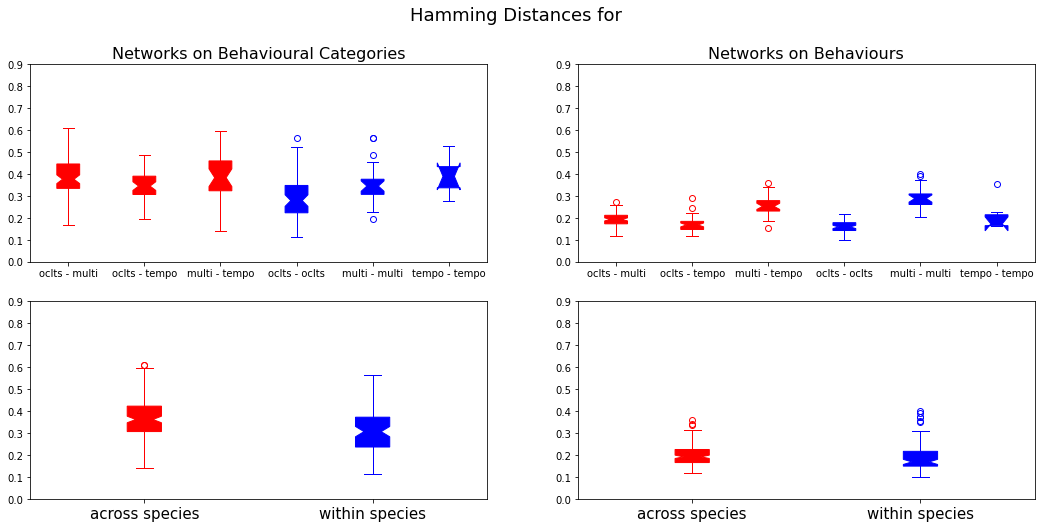

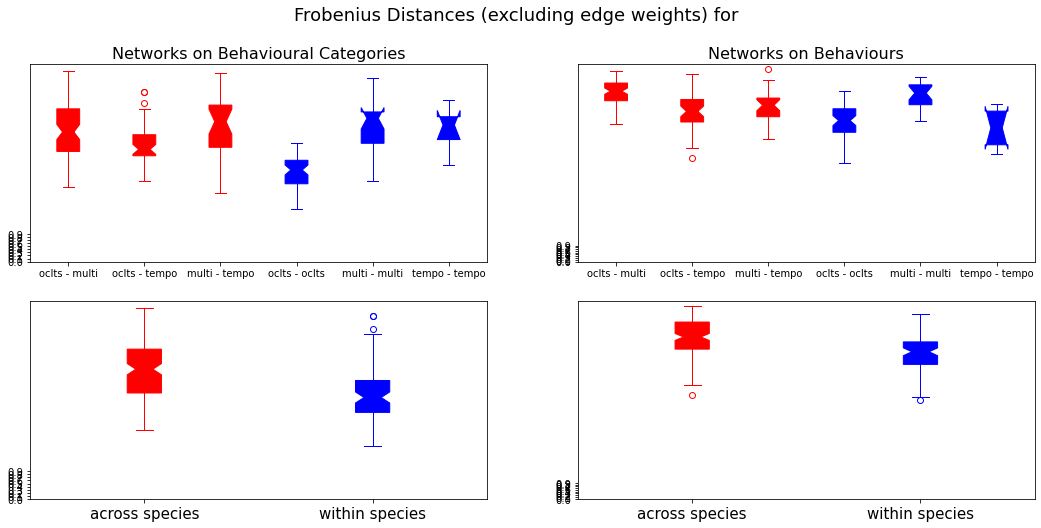

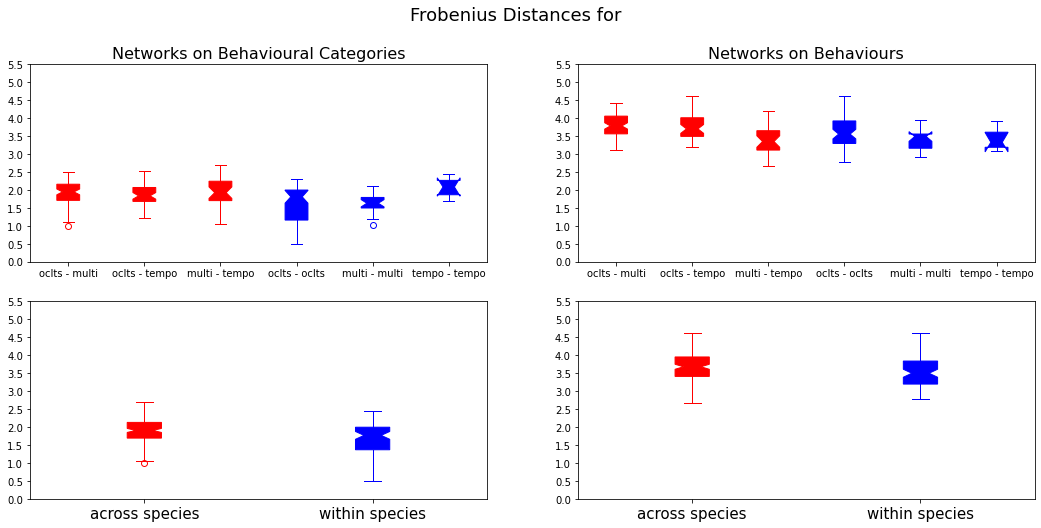

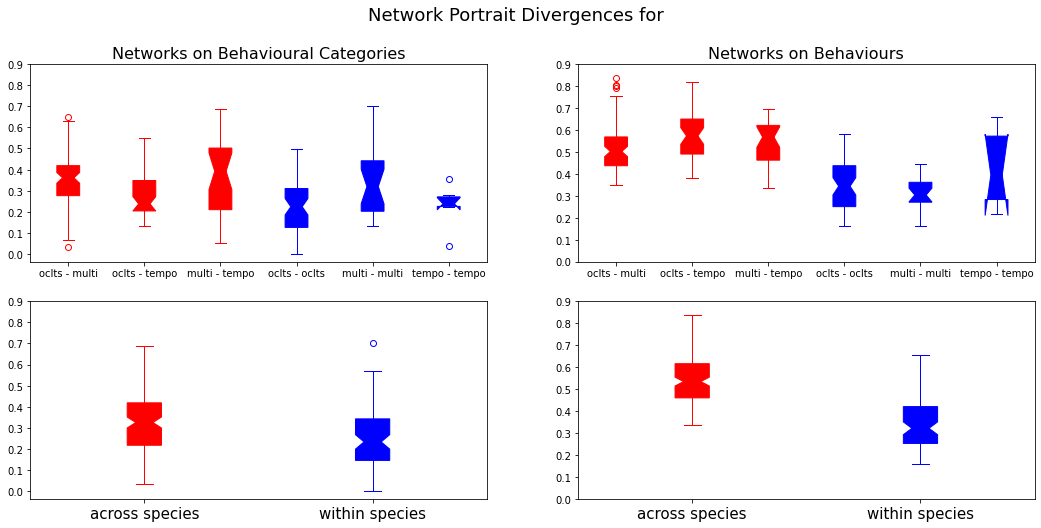

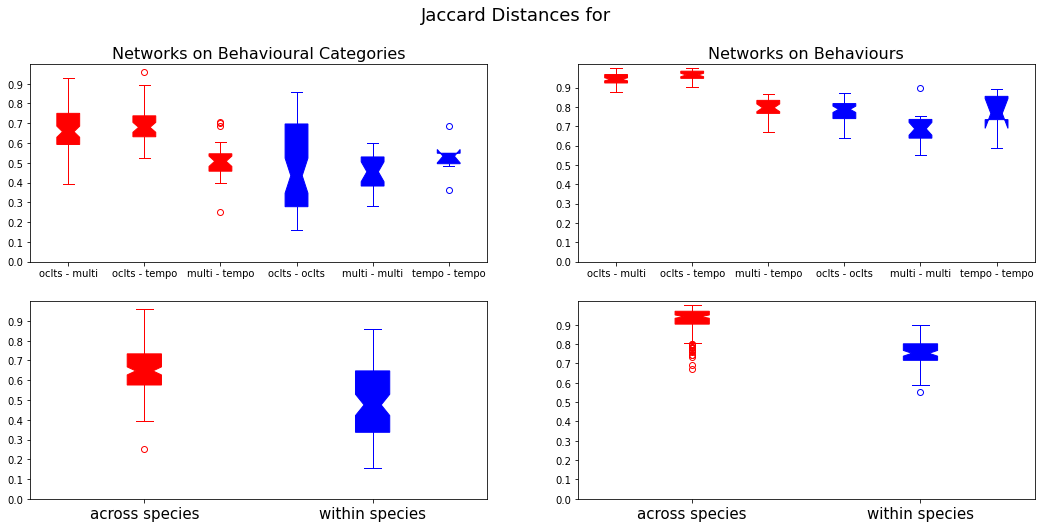

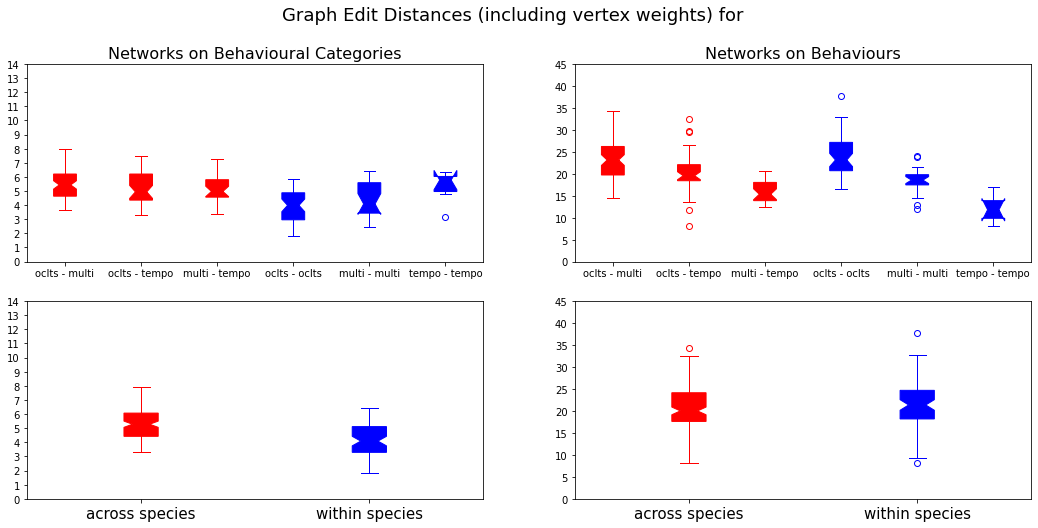

In [9]:
import matplotlib.patches as mpatches

algs = ['hamming', 'frobenius', 'weighted_frobenius', 'portrait_divergence', 
        'jaccard_distance', 'ged']

for alg in algs:
    alg_df = df[df.alg == alg]
    
    #behavioural category data gen
    bhvr_df = alg_df[alg_df.type == 'behavioural category']
    data = []
    labels = []
    i=0
    while (i < len(bhvr_df)):
        data.append(bhvr_df.iloc[i]['results'])
        labels.append(bhvr_df.iloc[i]['data1'] + " - " +bhvr_df.iloc[i]['data2'])
        i = i+1
        
    #behaviour data gen
    bhvr_df = alg_df[alg_df.type == 'behaviour']
    data_bhvr = []
    labels_bhvr = []
    i=0
    while (i < len(bhvr_df)):
        data_bhvr.append(bhvr_df.iloc[i]['results'])
        labels_bhvr.append(bhvr_df.iloc[i]['data1'] + " - " +bhvr_df.iloc[i]['data2'])
        i = i+1
        
       
    #behavioural category plot
    c = 'red'
    fig, axs = plt.subplots(2,2, figsize=(18,8))
    axs[0,0].boxplot(data[:3], positions=[1,2,3], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    c='blue'
    axs[0,0].boxplot(data[3:], positions=[4,5,6], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    axs[0,0].set_title('Networks on Behavioural Categories', size=16)
    axs[0,0].set_xticklabels(labels)
    
    #behaviour plot
    c = 'red'
    axs[0,1].boxplot(data_bhvr[:3], positions=[1,2,3], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    c='blue'
    axs[0,1].boxplot(data_bhvr[3:], positions=[4,5,6], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            
            )
    axs[0,1].set_title('Networks on Behaviours', size=16)
    axs[0,1].set_xticklabels(labels_bhvr)
    
    #title
    if (alg == 'weighted_jaccard'):
        fig.suptitle("Weighted Jaccard Distances for", size=18)
    elif (alg == 'jaccard_distance'):
        fig.suptitle("Jaccard Distances for", size=18)
    elif (alg == 'hamming'):
        fig.suptitle("Hamming Distances for", size=18)
    elif (alg == 'frobenius'):
        fig.suptitle("Frobenius Distances (excluding edge weights) for", size=18)
    elif (alg == 'portrait_divergence'):
        fig.suptitle("Network Portrait Divergences for", size=18)
    elif (alg == 'ged'):
        fig.suptitle("Graph Edit Distances (including vertex weights) for", size=18)
    elif (alg == 'weighted_frobenius'):
        fig.suptitle("Frobenius Distances for", size=18)
    else:
        fig.suptitle(alg.upper(), size=16)
    
    
    
    
    
# generalized data plots below normal data

    alg_df = general_df[general_df.alg == alg]

    #behavioural category data gen
    bhvr_df = alg_df[alg_df.type == 'behavioural category']
    data = []
    labels = []
    i=0
    while (i < len(bhvr_df)):
        data.append(bhvr_df.iloc[i]['results'])
        labels.append(bhvr_df.iloc[i]['data'])
        i = i+1

    #behaviour data gen
    bhvr_df = alg_df[alg_df.type == 'behaviours']
    data_bhvr = []
    labels_bhvr = []
    i=0
    while (i < len(bhvr_df)):
        data_bhvr.append(bhvr_df.iloc[i]['results'])
        labels_bhvr.append(bhvr_df.iloc[i]['data'])
        i = i+1

       
    #behavioural category plot
    c = 'red'
    axs[1,0].boxplot(data[:1], positions=[1], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    c='blue'
    axs[1,0].boxplot(data[1:], positions=[2], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    axs[1,0].set_xticklabels(labels, size=15)
    
    
    #general behaviour plot
    c = 'red'
    axs[1,1].boxplot(data_bhvr[:1], positions=[1], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    c='blue'
    axs[1,1].boxplot(data_bhvr[1:], positions=[2], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
   
    axs[1,1].set_xticklabels(labels_bhvr, size=15)
    
    
    #set yticks
    if (alg == 'ged'):
        axs[1,1].yaxis.set_ticks(np.arange(0, 50, 5))
        axs[0,1].yaxis.set_ticks(np.arange(0, 50, 5))
        axs[1,0].yaxis.set_ticks(np.arange(0, 15, 1))
        axs[0,0].yaxis.set_ticks(np.arange(0, 15, 1))
        
    elif (alg == 'weighted_frobenius'):
        axs[1,1].yaxis.set_ticks(np.arange(0, 6, 0.5))
        axs[0,1].yaxis.set_ticks(np.arange(0, 6, 0.5))
        axs[1,0].yaxis.set_ticks(np.arange(0, 6, 0.5))
        axs[0,0].yaxis.set_ticks(np.arange(0, 6, 0.5))
    else:
        axs[1,1].yaxis.set_ticks(np.arange(0, 1, 0.1))
        axs[0,1].yaxis.set_ticks(np.arange(0, 1, 0.1))
        axs[1,0].yaxis.set_ticks(np.arange(0, 1, 0.1))
        axs[0,0].yaxis.set_ticks(np.arange(0, 1, 0.1))
        

    
    
    
    # Adding title and legend
    #red_patch = mpatches.Patch(color='red', label='Comparison ACROSS species')
    #blue_patch = mpatches.Patch(color='blue', label='Comparison WITHIN species')
    #fig.legend(handles=[red_patch, blue_patch])
    # show plot
    plt.show()
    



In [ ]:
def flatten(t):
    return [item for sublist in t for item in sublist]

# weighted jaccard

- edge label auf edge mappen
- kleineren durch größeren teilen, dann schnittmenge dementsprechend verkleinern

In [ ]:
"""
Returns Jaccard distance for weighted directed networks 
"""
def weighted_jaccard(g1,g2):
    e1 = set(g1.edges)
    e2 = set(g2.edges)
    cup = set.union(e1, e2)
    cap = set.intersection(e1, e2)

    #if edge weights are different only add the relative accordance
    relative_sum = 0
    for edge in cap:

        w1 = g1.get_edge_data(edge[0], edge[1])["label"]
        w2 = g2.get_edge_data(edge[0], edge[1])["label"]
        if w1 > w2:
            relative_sum = relative_sum + (w2 / w1)
        elif w2 > w1:
            relative_sum = relative_sum + (w1 / w2)
        else:
            relative_sum = relative_sum +1

    dist = 1 - relative_sum / len(cup)
    return dist
    
g1 = nx.read_gpickle("/Users/nicol/Desktop/bachelorthesis/data/multi-categories/Multi_12_10_17_a2_first_15_02_19.gpickle")
g2 = nx.read_gpickle("/Users/nicol/Desktop/bachelorthesis/data/multi-categories/Multi_12_10_17_e1_first_19_02_19.gpickle")

dist = weighted_jaccard(g1,g2)
dist

In [ ]:
import time

#GED not working, laptop is failing

results= []
networkx_algs = ['ged']
for alg in networkx_algs:
    alg_name = alg
    
    #BEHAVIOURS PAIRWISE
    for data1, data2 in itertools.combinations(behaviours, 2):
        #folder names for adding in dataframe
        folder1 = str(data1).split("/")[6]
        folder2 = str(data2).split("/")[6]
        #compare each folder with each other
        for a in data1:
            for b in data2:

                #read gpickles into networkx
                g1 = nx.read_gpickle(a)
                g2 = nx.read_gpickle(b)

                #networkx optimized function for graph edit distance
                timeout = time.time() + 5
                for v in nx.optimize_graph_edit_distance(g1, g2):
                    minv = v
                    print(time.time())
                    if time.time() > timeout:
                        break
                results.append(minv)
                print(minv)


        #calculate statistics
        df.loc[len(df.index)] = [alg_name,folder1, folder2, results]
        results = []
        
        
df






    


## pie chart for threads and limitations

In [ ]:
import matplotlib.pyplot as plt

# make the pie circular by setting the aspect ratio to 1
plt.figure(figsize=(10, 5))
nur_o = 5
om = 1
mt = 2
rest = 17
values = [nur_o, om, mt, rest]
labels = ["L. Ocellatus","L. Ocellatus & N. Multifasciatus", "T. Temporalis & N. Multifasciatus", "All species" ]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(values, labels=labels, autopct=make_autopct(values), startangle=90, textprops = dict(size=11.2))

plt.show()

In [ ]:
import numpy as np
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))

recipe = ["5 L. Ocellatus",
          "1 L. Ocellatus & N. Multifasciatus",
          "2 N. Multifasciatus & T. Temporalis",
          "17 All species"]

data = [float(x.split()[0]) for x in recipe]
ingredients = [x.split()[1:] for x in recipe]
ingredients[2] = ' '.join(ingredients[2])
ingredients[3] = ' '.join(ingredients[3])
ingredients[1] = ' '.join(ingredients[1])
ingredients[0] = ' '.join(ingredients[0])
 
def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} )".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), startangle = 90, shadow=True)

ax.legend(wedges, ingredients,
          title="Species",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=10, weight="bold")

plt.show()

In [ ]:

import os
import numpy as np
import netrd, networkx as nx
import statistics
import pandas as pd
import itertools
import matplotlib.pyplot as plt


"""
lists directory, each element with its full path
"""
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]


oce = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/0o/")
tem = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/0t/")
mul = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/0m/")

oce_sizes = []
tem_sizes = []
mul_sizes = []

for elem in oce:
    df = pd.read_excel(elem)
    df = df.iloc[14:]
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    oce_sizes.append(len(df))
    
for elem in tem:
    df = pd.read_excel(elem)
    df = df.iloc[14:]
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    tem_sizes.append(len(df))

for elem in mul:
    df = pd.read_excel(elem)
    df = df.iloc[14:]
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    mul_sizes.append(len(df))
    




In [ ]:
oce_sizes, tem_sizes, mul_sizes

In [ ]:


fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(y=[2]*12, x=oce_sizes, c='green', alpha=0.5, s=150, edgecolor='black')
ax1.scatter(y=[3]*7, x=mul_sizes, c='red', alpha=0.5, s=150, edgecolor='black')
ax1.scatter(y=[1]*4, x=tem_sizes, c='blue', alpha=0.5, s=150, edgecolor='black')
#ax1.annotate('Species', xy=(0, 1), xytext=(-50,20), ha='left', va='top', xycoords='axes fraction', textcoords='offset points', fontsize=13)
ax1.annotate('Size (in rows)', xy=(0.98, 0), xytext=(1.06,0), ha='left', va='top', xycoords='axes fraction', fontsize=14)
plt.yticks([0.5,1,2,3,3.5], labels = ['','T. Temporalis' ,'L. Ocellatus', 'N. Multifasciatus',''])
plt.title('Amount and sizes of single datasets', size=14, pad=20)
plt.ylabel('Species', size=14)
plt.show()

In [ ]:
min(oce_sizes), sum(oce_sizes)/len(oce_sizes), max(oce_sizes)
min(tem_sizes), sum(tem_sizes)/len(tem_sizes), max(tem_sizes)
#min(mul_sizes), sum(mul_sizes)/len(mul_sizes), max(mul_sizes)

# results

In [ ]:
import scipy

def hamming(G1,G2):
    
   
        
    not_in_g1 = np.setdiff1d(G2.nodes(),G1.nodes())
    G1.add_nodes_from(not_in_g1)
    not_in_g2 = np.setdiff1d(G1.nodes(),G2.nodes())
    G2.add_nodes_from(not_in_g2)

    N = G1.number_of_nodes()
    
    adj1 = nx.to_numpy_array(G1)
    adj2 = nx.to_numpy_array(G2)

    # undirected case: consider only upper triangular
    mask = np.triu_indices(N, k=1)

    # directed case: consider all but the diagonal
    if nx.is_directed(G1) or nx.is_directed(G2):
        new_mask = np.tril_indices(N, k=-1)
        mask = (np.append(mask[0], new_mask[0]), np.append(mask[1], new_mask[1]))

    # only if there are self-loops include the diagonal
    # this corrects the implicit denominator of Hamming, which
    # should be N^2 for networks with self-loops and N(N-1) for
    # those without
    if next(nx.selfloop_edges(G1), False) or next(nx.selfloop_edges(G2), False):
        new_mask = np.diag_indices(N)
        mask = (np.append(mask[0], new_mask[0]), np.append(mask[1], new_mask[1]))

    dist = scipy.spatial.distance.hamming(
        adj1[mask].flatten(), adj2[mask].flatten()
    )

    print(adj1)
    print(adj2)
    print(dist)
    
    return dist

hamming(g1,g2)

In [ ]:
möglichkeiten für weighted hamming:
    
    - adjazenzmatrix mit transition probabilities
    - n verkleinern

In [ ]:
g1 = nx.read_gpickle("/Users/nicol/Desktop/bachelorthesis/data/normalized/ocellatus-categories/Ocellatus_03_11_19_1-6(1).gpickle")
g2 = nx.read_gpickle("/Users/nicol/Desktop/bachelorthesis/data/normalized/ocellatus-categories/Ocellatus_03_11_19_7-8_2(1).gpickle")

def weighted_frobenius(g1,g2):

    #print(nx.get_edge_attributes(g1, label))
    not_in_g1 = np.setdiff1d(g2.nodes(),g1.nodes())
    g1.add_nodes_from(not_in_g1)
    not_in_g2 = np.setdiff1d(g1.nodes(),g2.nodes())
    g2.add_nodes_from(not_in_g2)
    
    adj1 = nx.to_numpy_array(g1, weight="label")
    adj2 = nx.to_numpy_array(g2, weight="label")
    dist = np.linalg.norm((adj1 - adj2))
    print(adj1)
    print(adj2)
    print(dist)
    
    return dist

weighted_frobenius(g1,g2)

In [13]:
import networkx as nx

#g1 = nx.read_gpickle("/Users/nicol/Desktop/bachelorthesis/data/normalized/ocellatus-categories/Ocellatus_03_11_19_1-6(1).gpickle")
#g2 = nx.read_gpickle("/Users/nicol/Desktop/bachelorthesis/data/normalized/ocellatus-categories/Ocellatus_03_11_19_7-8_2(1).gpickle")


g1 = nx.read_gpickle("/Users/nicol/Desktop/bachelorthesis/data/normalized_new/multi-categories/Multi_12_10_17_e1_first_19_02_19.gpickle")
g2 = nx.read_gpickle("/Users/nicol/Desktop/bachelorthesis/data/normalized_new/multi-categories/Multi_12_10_17_e1_second_01_04_19.gpickle")



def edge_subst(g1edge, g2edge):
    cost = abs(g1edge['label']-g2edge['label'])
    return cost
    
def edge_cost(edge):
    cost = abs(edge['label'])
    return cost

def node_cost(node):
    cost = node['avg_time']
    return cost

def node_subst(node1,node2):
    cost = abs(node1['avg_time']-node2['avg_time'])
    return cost

"""
Returns GED 
"""
def ged(g1,g2):
    dist = nx.graph_edit_distance(g1, g2, edge_subst_cost=edge_subst, 
                                  edge_ins_cost=edge_cost, edge_del_cost=edge_cost, 
                                  node_ins_cost=node_cost, node_del_cost=node_cost,
                                  node_subst_cost=node_subst, timeout=30)
    return dist

ged(g1,g2)

3.4194280155147565

In [15]:
import os
import numpy as np
import netrd, networkx as nx
import statistics
import pandas as pd
import itertools
import matplotlib.pyplot as plt


"""
lists directory, each element with its full path
"""
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]



#lists with the files
oce_bvr = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized_new/ocellatus-behaviours/")
mul_bvr = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized_new/multi-behaviours/")
tem_bvr = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized_new/tempo-behaviours/")

oce_ctg = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized_new/ocellatus-categories/")
mul_ctg = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized_new/multi-categories/")
tem_ctg = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized_new/tempo-categories/")

behaviours = [tem_bvr, oce_bvr, mul_bvr]
categories = [oce_ctg, mul_ctg, tem_ctg]


distance_algs =  ['ged']
algs = ['ged']

results= []
df = pd.DataFrame(columns=['alg', 'data1', 'data2', 'results'])
general_df = pd.DataFrame(columns=['alg', 'data', 'type', 'results'])

for alg in distance_algs:
    alg_name = alg
    print(alg_name)
    
    #lists for specieal results
    bhvr_across_species = []
    bhvr_within_species = []
    cat_across_species = []
    cat_within_species = []
    
#BEHAVIOURS SINGLE
    for data in behaviours:
        #folder names for adding in dataframe
        folder1 = str(data).split("/")[7]
        folder2 = str(data).split("/")[7]
        #compare each folder with each other
        print(len(data), folder1, folder2)
        for a,b in itertools.combinations(data, 2):

                #read gpickles into networkx
                g1 = nx.read_gpickle(a)
                g2 = nx.read_gpickle(b)
                
                for edge in g1.edges:
                    weight = g1.get_edge_data(edge[0],edge[1])['label']
                    g1[edge[0]][edge[1]]['weight'] = weight
                    
                for edge in g2.edges:
                    weight = g2.get_edge_data(edge[0],edge[1])['label']
                    g2[edge[0]][edge[1]]['weight'] = weight


                dist = ged(g1,g2)
                results.append(dist)
                print(dist)
                
        print(results)
        results = []

ged
4 tempo-behaviours tempo-behaviours
14.514706705374262
11.651165373940428
17.016029698574755
8.06168063478566
9.261731878277851
11.952132859147756
[14.514706705374262, 11.651165373940428, 17.016029698574755, 8.06168063478566, 9.261731878277851, 11.952132859147756]
10 ocellatus-behaviours ocellatus-behaviours
20.33023917596298
21.63791727042784
24.80703629021125
16.493020803461814
22.694491575617022
21.779079365387677
27.140982978373522
21.45071035829252
18.56096013091792
28.93484757222239
30.870298910149206
25.030890615004406
32.81296610116159
31.474491933916394
37.64286213867778
31.978937354117278
27.960238737339083
20.052447321594364
22.594552436337054
22.775379289615692
19.89642250746264
27.15887270249131
22.083375942918767
20.69213720517674
18.19363639536565
24.64979818934078
24.46988340032383
26.49498320695727
22.89212489898919
20.08086812782848
26.65897980809077
23.293885260126167
31.47353373578842
23.780228576589508
22.27995997331294
23.130168525332227
28.87426679009862
21.5

In [14]:
# COMPARISONS ACROSS SPECIES


import os
import numpy as np
import netrd, networkx as nx
import statistics
import pandas as pd
import itertools
import matplotlib.pyplot as plt


"""
lists directory, each element with its full path
"""
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]



#lists with the files
oce_bvr = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized_new/ocellatus-behaviours/")
mul_bvr = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized_new/multi-behaviours/")
tem_bvr = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized_new/tempo-behaviours/")

oce_ctg = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized_new/ocellatus-categories/")
mul_ctg = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized_new/multi-categories/")
tem_ctg = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized_new/tempo-categories/")

behaviours = [tem_bvr, oce_bvr, mul_bvr]
categories = [oce_ctg, mul_ctg, tem_ctg]


distance_algs =  ['ged']
algs = ['ged']

results= []
df = pd.DataFrame(columns=['alg', 'data1', 'data2', 'results'])
general_df = pd.DataFrame(columns=['alg', 'data', 'type', 'results'])

for alg in distance_algs:
    alg_name = alg
    print(alg_name)
    
    #lists for specieal results
    bhvr_across_species = []
    bhvr_within_species = []
    cat_across_species = []
    cat_within_species = []
    
        
    #BEHAVIOURS PAIRWISE
    for data1, data2 in itertools.combinations(behaviours, 2):
        #folder names for adding in dataframe
        folder1 = str(data1).split("/")[7]
        folder2 = str(data2).split("/")[7]
        print(folder1,folder2)
        #compare each folder with each other
        for a in data1:
            for b in data2:

                #read gpickles into networkx
                g1 = nx.read_gpickle(a)
                g2 = nx.read_gpickle(b)
                
                for edge in g1.edges:
                    weight = g1.get_edge_data(edge[0],edge[1])['label']
                    g1[edge[0]][edge[1]]['weight'] = weight
                    
                for edge in g2.edges:
                    weight = g2.get_edge_data(edge[0],edge[1])['label']
                    g2[edge[0]][edge[1]]['weight'] = weight


                dist = ged(g1,g2)
                results.append(dist)
                print(dist)
        print(results)
        results = []

ged
tempo-behaviours ocellatus-behaviours
16.166097756285296
26.515078242254138
20.099037833051273
18.61152286495425
19.536311286442807
18.847118247457757
21.2962768865162
32.544514359205394
22.341787104615147
19.61419950566104
11.857277100457262
26.076262978116674
18.735571446214944
22.010181077259617
19.134171259961157
19.20522343717862
19.883578043713875
29.633740907197613
22.225304525808177
18.532244153325436
13.478641063149468
23.404104086948525
19.5583884071757
20.236959014214456
18.592552711717595
18.48156117344199
17.660761765589363
25.958088909899026
16.826913561601263
13.632774969747029
8.11871430361386
22.2923648377065
20.725434000150752
21.572889414415176
18.19839947437725
18.485284653697274
16.677031850515956
29.426423941248494
20.35095574247492
14.757498382260204
[16.166097756285296, 26.515078242254138, 20.099037833051273, 18.61152286495425, 19.536311286442807, 18.847118247457757, 21.2962768865162, 32.544514359205394, 22.341787104615147, 19.61419950566104, 11.857277100457